Vision Convnet
==============



The goal of this project is to do some basic image classification and to build an interpretable model. For this case, we&rsquo;ll use a relatively obscure and small [Kaggle animal dataset](https://www.kaggle.com/datasets/alessiocorrado99/animals10) with 10 animal classes: dog, cat, horse, spider, butterfly, chicken, sheep, cow, squirrel, and elephant.
Given that its of unknown quality, we&rsquo;ll first check to see if there&rsquo;s anything unusual about the images, and then build a simple classifier we train on the dataset directly.
First, we use Kaggle&rsquo;s api to get the dataset via `kaggle datasets download -d alessiocorrado99/animals10`. The file structure is in Italian, so for my ease at least I&rsquo;m going to translate the folder names to English using their brief dictionary



In [1]:
import os
working_data_dir = "/fasterHome/workingDataDir/kaggle/animals10"
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno": "spider"}
for folder in os.listdir(os.path.join(working_data_dir, "raw-img")):
    contained = os.path.join(working_data_dir, "raw-img", folder)
    if folder in translate:
        os.rename(contained, os.path.join(working_data_dir, "raw-img", translate[folder]))

And one more essential piece of housekeeping: import statements



In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as nnF
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.transforms.functional as tvFun
from torch.utils.data import DataLoader
from torch import optim
from skimage import io, transform

/fasterHome/anaconda3/envs/kaggle/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


That out of the way, we define some parameters of the process, such as batch size, maximum image size (`target_size`), the number of batches per accuracy sample (`running_average_size`), test split, a seed for reproducibility, and the number of total epochs.



In [3]:
batch_size = 5
target_size = 800
running_average_size = 100
split_seed = 42
test_split = 0.2
n_epochs = 60

Lets define some functions so that batches are collated to the same size.



In [4]:
all_images = tv.datasets.ImageFolder(
    os.path.join(working_data_dir, "raw-img"), transform=tv.transforms.ToTensor(),
)
def needed_pad(x: torch.Tensor, max_size: torch.Size):
    """pad `x` so that it's last two dimensions have size `max_size`"""
    diff = np.array(max_size) - np.array(x.shape[-2:])
    diff = diff / 2
    return nnF.pad(
        x,
        (
            int(np.floor(diff[1])),
            int(np.ceil(diff[1])),
            int(np.floor(diff[0])),
            int(np.ceil(diff[0])),
        ),
    )

def collate_unevenly_sized(batch_iter):
    """collation function. first it checks that all images are smaller than `target_size`, and subsamples so that they are approximately below `target_size` using 2D average pooling. Then it pads all images so they match the largest in the batch"""
    images, labels = zip(*batch_iter)
    max_size, _ = torch.max(torch.tensor([t.shape[-2:] for t in images]), dim=0)
    if (max_size >= target_size).any():
        tmp = [image for image in images]
        for ii, image in enumerate(images):
            sz = torch.tensor(image.shape[-2:])
            if (sz >= target_size).any():
                rate = torch.ceil(sz / target_size).to(int)
                pooler = nn.AvgPool2d((rate[0], rate[1]))
                tmp[ii] = pooler(image)
        images = tmp
    max_size, _ = torch.max(torch.tensor([t.shape[-2:] for t in images]), dim=0)
    images = torch.cat([needed_pad(x, max_size).unsqueeze(0) for x in images], dim=0)
    labels = nnF.one_hot(torch.tensor(labels), num_classes=10).to(torch.float)
    return images, labels

# generate a simple train/test split
dataset_size = len(all_images)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.seed(split_seed)
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)

train_loader = DataLoader(
    all_images,
    collate_fn=collate_unevenly_sized,
    batch_size=batch_size,
    sampler=train_sampler,
)
test_loader = DataLoader(
    all_images,
    collate_fn=collate_unevenly_sized,
    batch_size=batch_size,
    sampler=test_sampler,
)

Finally, lets take a look at some of the images:



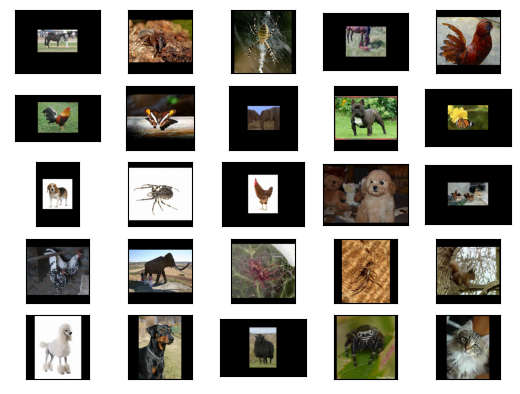

In [5]:
n_imgs = 25
ncols=5
plt.rcParams["savefig.bbox"] = 'tight'
fig, axs = plt.subplots(ncols=ncols, nrows=n_imgs//ncols, squeeze=False)
for ii, img in enumerate(train_loader):
    axs[ii//ncols, ii%ncols].imshow(torch.permute(img[0][0,:].squeeze(), (1,2,0)))
    axs[ii//ncols, ii%ncols].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if ii==n_imgs-1:
        break

So we have a mix of pre-segmented images with a white background, more natural images with various backgrounds, and some cartoons. The variation in resolution is high, which could pose some difficulty; depending on how well or poorly the classifier does, we may want to upsample any particularly small images and perform more general data transformations which should be irrelevant (translation, rotation, dilation etc). The subject is generally centered, generally takes up most of the image, and is frequently the only object present (except for horses, apparently, which frequently include riders).



## Defining a initial convnet



We define some convenience module classes first; the first gives us a resnet-like set of parallel convolution layers with filters of various sizes



In [6]:
class MultiFilterLayer(nn.Module):
    """Maintains the size, applying 3 filterbanks of different sizes, then do a batch norm, and finally a mixing filter (1x1 convolution) that also subsamples. Generally inspired by the ResNet architecture."""

    def __init__(
        self,
        nchannels_in,
        nchannels_out,
        nonlin,
        norm_layer,
        filterSizes=(3, 5, 7),
        stride=2,
    ):
        super(MultiFilterLayer, self).__init__()
        self.norm = norm_layer(sum(nchannels_out[0:3]))
        self.nonlin = nonlin
        self.conv1 = nn.Conv2d(
            nchannels_in, nchannels_out[0], kernel_size=filterSizes[0], padding="same"
        )
        self.conv2 = nn.Conv2d(
            nchannels_in, nchannels_out[1], kernel_size=filterSizes[1], padding="same"
        )
        self.conv3 = nn.Conv2d(
            nchannels_in, nchannels_out[2], kernel_size=filterSizes[2], padding="same"
        )
        self.conv_next = nn.Conv2d(
            sum(nchannels_out[0:3]), nchannels_out[3], kernel_size=1, stride=stride
        )

    def forward(self, x):
        x = torch.cat((self.conv1(x), self.conv2(x), self.conv3(x)), dim=1)
        x = self.norm(x)
        x = self.nonlin(x)
        x = self.conv_next(x)
        return x

`FullyConnected` constructs a series of fully connected layers, given a list of the sizes of each layer and the nonlinearity used between layers.



In [7]:
class FullyConnected(nn.Module):
    """a fully connected set of layers, where `nodes_per_layer` is a list of the number of nodes in the ith layer for i>0, while the 0th entry is the size of the input. Between each layer is an application of the function `nonlin`."""

    def __init__(self, nodes_per_layer, nonlin=None):
        super(FullyConnected, self).__init__()
        if nonlin is None:
            nonlin = nn.ReLU6()
        self.layers = nn.ModuleList(
            [
                nn.Linear(nodes_per_layer[ii - 1], node)
                for (ii, node) in enumerate(nodes_per_layer)
                if ii > 0
            ]
        )
        self.nonlin = nonlin

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.nonlin(x)
        return nnF.log_softmax(x, dim=1)

Finally, Animal10 creates a resnet-like architecture by putting together a user specified number of `MulitiFilterLayer`, an adaptive average to make sure the number of entries is fixed, and then a `FullyConnected` set of layers.



In [8]:
class Animal10(nn.Module):
    """a set of multi-filter size convolutional layers, defined by `nchannels_multifilters` and `filterSizes`, followed by a set of fully connected layers, defined by `nfully_connected` (the first entry of n_fully_connected corresponds to the size of ). The nonlinearity `nonlin` is used univerally between all layers, while `norm_layer` defines the kind of batch norm used by the `MulitiFilterLayer`s."""

    def __init__(
        self,
        nchannels_multifilters,
        filterSizes,
        nfully_connected,
        nonlin=None,
        norm_layer=None,
        strides=None,
    ):
        super(Animal10, self).__init__()
        if nonlin is None:
            nonlin = nn.ReLU()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if strides is None:
            strides = [2 for _ in range(len(filterSizes))]

        # define the conv layers
        multiFilters = []
        for (ii, nchannels) in enumerate(nchannels_multifilters[:-1]):
            previous_out_channels = nchannels[-1]
            current_nchannels = nchannels_multifilters[ii + 1]
            multiFilters.append(
                MultiFilterLayer(
                    previous_out_channels,
                    current_nchannels,
                    nonlin,
                    norm_layer,
                    filterSizes[ii],
                    strides[ii],
                )
            )
        self.multiFilters = nn.ModuleList(multiFilters)
        self.adaptiveAve = nn.AdaptiveAvgPool2d((1, 1))
        # define the fully connected layers
        self.fullyConnected = FullyConnected(
            [nchannels_multifilters[-1][-1], *nfully_connected], nonlin
        )

    def forward(self, x):
        for layer in self.multiFilters:
            x = layer(x)
        x = self.adaptiveAve(x)
        x = torch.flatten(x, 1)  # drop the spatial components
        x = self.fullyConnected(x)
        return x

## Training several models



Since Jupyter notebooks have a poor GPU memory footprint, the actual model training has been done in [script.py](script.py). Here we&rsquo;ll load the results of training and compare.



In [9]:
import sys
sys.path.append(".")
from models import MultiFilterLayer, FullyConnected, Animal10

There are 4 runs so far, all with 4 convolutional layers; the first model has fewer convolutional channels the latter two, while the second model has more fully connected layers, the third model has more convolutional channels output, and the final model has more convolutional filters.



In [10]:
runPostfixes = [filename[10:-4] for filename in os.listdir("runs/") if filename.startswith("lossRecord")]
loss_records = [np.load(f"runs/lossRecord{x}.npy") for x in runPostfixes]
nChannels = [np.load(f"runs/nChannels{x}.npy", allow_pickle=True) for x in runPostfixes]
filterSizes = [np.load(f"runs/filterSizes{x}.npy", allow_pickle=True) for x in runPostfixes]
fully_connected = [np.load(f"runs/fully_connected{x}.npy", allow_pickle=True) for x in runPostfixes]
strides = [np.load(f"runs/strides{x}.npy", allow_pickle=True) for x in runPostfixes]
for x in [Animal10(nChannels[ii], filterSizes[ii], fully_connected[ii], strides=strides[ii]) for ii in range(len(runPostfixes))]:
    print(x)

Animal10(
  (multiFilters): ModuleList(
    (0): MultiFilterLayer(
      (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ReLU()
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (conv3): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
      (conv_next): Conv2d(48, 64, kernel_size=(1, 1), stride=(2, 2))
    )
    (1): MultiFilterLayer(
      (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): ReLU()
      (conv1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (conv3): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (conv_next): Conv2d(48, 64, kernel_size=(1, 1), stride=(4, 4))
    )
    (2): MultiFilterLayer(
      (norm): BatchNorm2

Lets plot the loss, for each run along with the smoothed version.



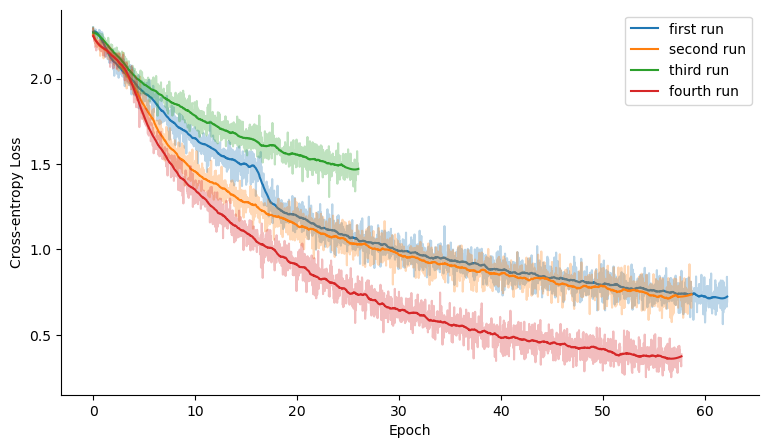

In [11]:
from scipy.signal import savgol_filter
import pandas as pd
max_len = max([len(x) for x in loss_records])
epoch = np.array(range(max_len)) * 100 /len(train_loader)
smoothed = [savgol_filter(x, 101, 3) for x in loss_records]
error = [np.abs(loss_records[ii] - smoothed[ii]) for ii in range(len(loss_records))]
fig, ax = plt.subplots(figsize=(9,5))
def plot_with_error_bars(x,raw,label,color):
    ax.plot(epoch[:len(x)], x, label=label, color=color)
    ax.plot(epoch[:len(x)], raw, color=color, alpha=0.3)
plot_with_error_bars(smoothed[0], loss_records[0], "first run", "tab:blue")
plot_with_error_bars(100*smoothed[1], 100*loss_records[1], "second run", "tab:orange")
plot_with_error_bars(100*smoothed[2], 100*loss_records[2], "third run", "tab:green")
plot_with_error_bars(100*smoothed[3], 100*loss_records[3], "fourth run", "tab:red")
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy Loss')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

Since this is a cross-entropy loss for exact labels, we can interpret the value as $-\log(p(\textrm{correct label}))$; random guessing is then $\log\big(\frac{1}{10}\big)\approx 2.3$ which is approximately where the error starts. After training, the last model assigns a probability of



In [12]:
(smoothed[-1][-1], np.exp(-smoothed[-1][-1]))

(0.0037379531566012363, 0.9962690242937976)

to the correct value, while the first model assigns a probability of



In [13]:
np.exp(-smoothed[0][-1])

0.48497356496045063

To see whether the last model&rsquo;s high accuracy on the training set is a sign of correct learning or overfitting, lets evaluate the model on the training set:



In [15]:
def evaluate_model_n(model_no):
    animal_classifier = Animal10(nChannels[model_no], filterSizes[model_no], fully_connected[model_no], strides=strides[model_no])
    animal_classifier.load_state_dict(torch.load(f"runs/model{runPostfixes[model_no]}.pth"))
    animal_classifier.eval()
    device = torch.device("cuda")
    animal_classifier.to(device)
    top1 = 0
    top3 = 0
    classes = all_images.classes
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    total = 0
    with torch.no_grad():
        for ii, data in enumerate(test_loader):
            image_batch, labels = data
            image_batch = image_batch.to(device)

            _, sorted_pred = torch.sort(animal_classifier(image_batch), 1)
            top_3_pred = sorted_pred[:, -3:].to("cpu")
            top_pred = sorted_pred[:, -1].to("cpu")
            _, label_index = torch.max(labels, 1)
            total += labels.size(0)
            top1 += (top_pred == label_index).sum().item()
            top3 += (top_3_pred.T == label_index).any(0).sum().item()
            for label, prediction in zip(label_index, top_pred):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    correct_class = {classname: correct_pred[classname] / total_pred[classname] for classname in classes}
    print(f"total accuracy: {top1/total}")
    print(f"top-3 accuracy: {top3/total}")
    print(correct_class)
evaluate_model_n(0)

total accuracy: 0.6231136580706781
top-3 accuracy: 0.8832855778414518
{'butterfly': 0.6591478696741855, 'cat': 0.42359249329758714, 'chicken': 0.6340288924558587, 'cow': 0.5026178010471204, 'dog': 0.6314699792960663, 'elephant': 0.5225563909774437, 'horse': 0.5041152263374485, 'sheep': 0.5394736842105263, 'spider': 0.8805355303810505, 'squirrel': 0.5141388174807198}


So the first model has an overall accuracy of ~62%, with spiders being the most accurately classified, while cat is the most confused



In [16]:
evaluate_model_n(1)

total accuracy: 0.5854823304680038
top-3 accuracy: 0.8632282712511938
{'butterfly': 0.7619047619047619, 'cat': 0.1769436997319035, 'chicken': 0.5858747993579454, 'cow': 0.48429319371727747, 'dog': 0.5838509316770186, 'elephant': 0.5300751879699248, 'horse': 0.5205761316872428, 'sheep': 0.5815789473684211, 'spider': 0.8619979402677652, 'squirrel': 0.33161953727506427}


The second model is a bit worse



In [17]:
evaluate_model_n(2)

total accuracy: 0.4808022922636103
top-3 accuracy: 0.623686723973257
{'butterfly': 0.6340852130325815, 'cat': 0.646112600536193, 'chicken': 0.7479935794542536, 'cow': 0.0, 'dog': 0.0, 'elephant': 0.0, 'horse': 0.5946502057613169, 'sheep': 0.631578947368421, 'spider': 0.8774459320288363, 'squirrel': 0.4524421593830334}


Perhaps unsurprisingly given its error on the training set, the third model had the worst accuracy at ~48%.
More importantly however, the cross entropy loss on the training data set is high, suggesting that none of the first 3 models are sufficiently expressive to capture the full variation in the data.
The final model, which has a low cross entropy has a test accuracy of



In [18]:
evaluate_model_n(3)

total accuracy: 0.6796561604584527
top-3 accuracy: 0.898567335243553
{'butterfly': 0.7393483709273183, 'cat': 0.4289544235924933, 'chicken': 0.7576243980738363, 'cow': 0.5785340314136126, 'dog': 0.6221532091097308, 'elephant': 0.6879699248120301, 'horse': 0.5905349794238683, 'sheep': 0.7105263157894737, 'spider': 0.8836251287332647, 'squirrel': 0.5424164524421594}


## More extensive model hyperparameter testing



## Data augmentation



## Doing some transfer learning



## Building an interpretable model

